In [34]:
'''Examination of the variance in the likelihood estimate of the particle filter for varying number of particles N with the Toy example 
in section 16.5.1 on Introduction to SMC By Chopin and Papaspiliopoulos.'''

import numpy as np
import matplotlib.pyplot as plt

from particle_filter import filter
from models import AR_model

In [35]:
rng = np.random.default_rng(5)

'''Model'''

model_params = {'rho':0.9,'sigma_x':1.,'sigma_y':1.2}

T = 100

X = np.zeros((T,))
X[0] = 0. 

Y = np.zeros((T,))
Y[0] = 0. 


for t in range(1,T): 
    X[t] = model_params['rho'] * X[t-1] + rng.normal(0,model_params['sigma_x'])
    Y[t] = X[t] + rng.normal(0,model_params['sigma_y'])


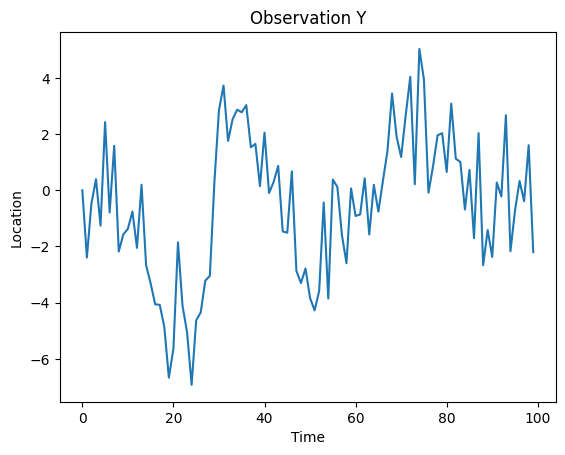

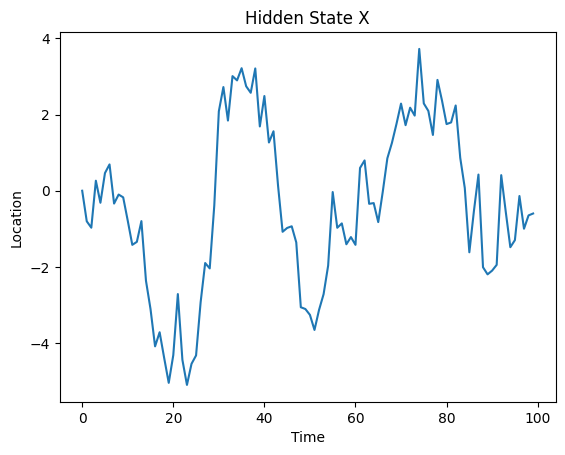

In [36]:
plt.title("Observation Y")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(Y)
plt.show()

plt.title("Hidden State X")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(X)
plt.show()

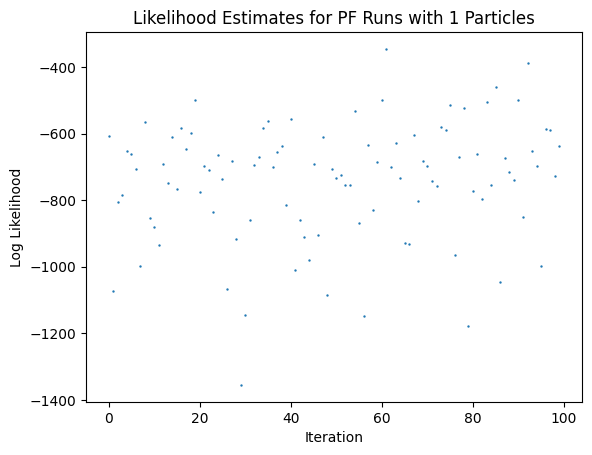

Statistics:
Variance is 31643.412035166803 and mean is -742.0918289715196


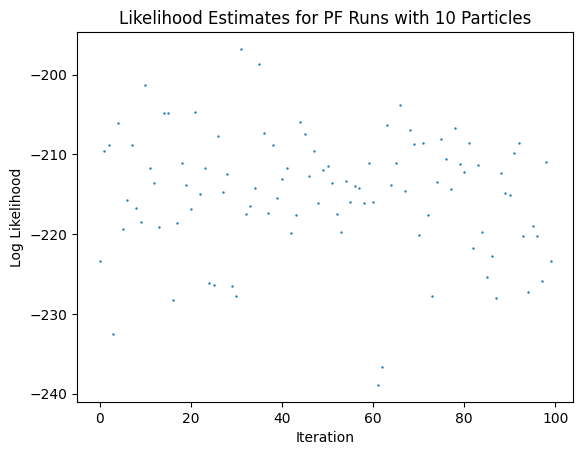

Statistics:
Variance is 56.82783824245982 and mean is -214.95521156739107


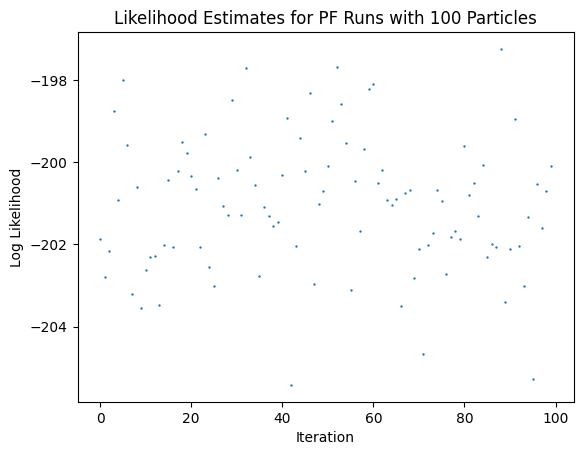

Statistics:
Variance is 2.625463368312748 and mean is -201.04899709951


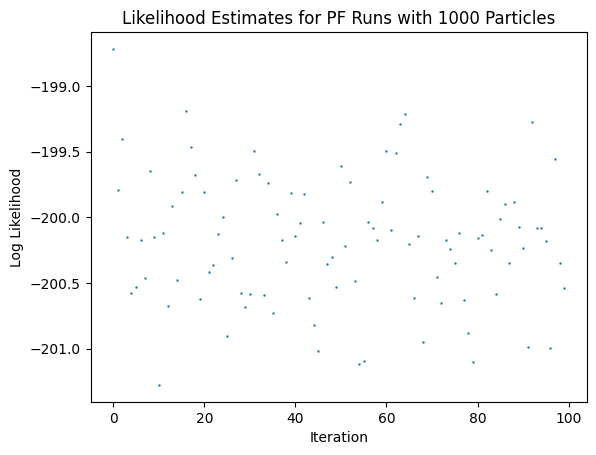

Statistics:
Variance is 0.2346812982911918 and mean is -200.1795810945304


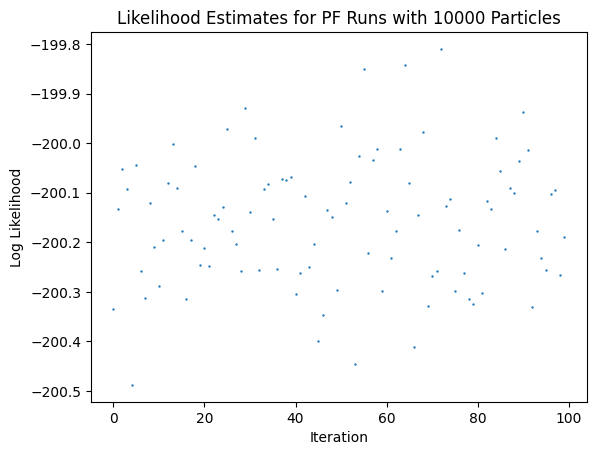

Statistics:
Variance is 0.016732068811490045 and mean is -200.15928901509687


In [37]:
iterations = 100
num_particles = [1,10,100,1000,10_000]

for i in range(len(num_particles)):
    LL_s = []
    for iter in range(iterations):
        *_,likelihood = filter(Y,theta = (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),dt = 1,rng = rng, model = AR_model,num_particles=num_particles[i])
        LL_s.append(np.sum(np.log(likelihood)))

    plt.title(f"Likelihood Estimates for PF Runs with {num_particles[i]} Particles")
    plt.scatter(np.arange(0,iterations,1),LL_s,s=0.5)
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.show()

    print("Statistics:")
    print(f"Variance is {np.var(LL_s)} and mean is {np.mean(LL_s)}")


### <center> Likelihood Computation Using the Kalman Filter

The Hidden Markov Model is defined as follows. A latent process is given where $A \in \mathbb{R}^{p \times k}$ and $F \in \mathbb{R}^{k \times k}$ and 
$v_t,w_t$ are vectors of parameterized Gaussian noise. 

$$
y_t = Ax_t + v_t \\
x_t = Fx_{t-1} + w_t \\
w_t \sim \mathcal{N}(0,W)\\
v_t \sim \mathcal{N}(0,V)


$$

Formally, the Likelihood for a Hidden Markov Model is the unnormalized joint density $p(y_1,\dots,y_T)$ for some time series of observations of a latent process indexed by $1,2,\dots,T$. We can factorize as follows by the conditional independence assumptions of the Markov process. 

$$
p(y_1)\prod_{i=2}^T p(y_i|y_{1:i-1})
$$

First we need to compute $p(y_1)$. We can do so by considering the joint density $p(y_1,x_1)$ and integrating with respect to $x_1$. 

$$
p(y_1,x_1) = p(y_1|x_1)p(x_1) \\
p(y_1) = \int p(y_1|x_1)p(x_1) dx_1
$$

Note that $p(y_1|x_1)$ is the observation density, and $p(x_1)$ is the posterior density the latent state. 

Thus we can write $p(y_1|x_1) = \mathcal{N}(Ax_0^{post},V)$ and $\mathcal{N}(Fx_0^{post},FP_{0}^{post}F^T + W)$ where superscript denotes the posterior estimate and $P$ is the running covariance in the Kalman Filter.

$$
\int \mathcal{N}(Ax_0^{post},V) \mathcal{N}(Fx_0^{post},FP_{0}^{post}F^T + W) dx_0 \\
= \mathcal{N}(Ax_0^{post},AP_{0}^{post}A^T + V)
$$

In general we require densities of the form $p(y_i|y_{1:i-1})$ which can be factorized as follows. 

$$
p(y_i|y_{1:i-1}) = \int p(y_i,x_i|y_{1:i-1}) dx_i \\
= \int p(y_i|x_i)p(x_i|y_{1:i-1})dx_i \\
=\mathcal{N}(Ax_{i-1}^{post},AP_{i-1}^{post}A^T + V)
$$